# BondGraphs.jl

In [1]:
] activate /home/carson/research/BondGraphs.jl/venv

# Import Packages

In [2]:
using BondGraphs
using ModelingToolkit
using DifferentialEquations
using Plots
using Symbolics
using SymbolicUtils
using Unitful
using UnitfulRecipes
using MonteCarloMeasurements
using Latexify

┌ Info: Precompiling BondGraphs [81b6dc42-80d7-44f0-b878-76c33e6b41d1]
└ @ Base loading.jl:1317
┌ Warning: Module OrdinaryDiffEq with build ID 44479620903844 is missing from the cache.
│ This may mean OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1008
┌ Warning: Module OrdinaryDiffEq with build ID 44479620903844 is missing from the cache.
│ This may mean OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1008
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for ParameterizedFunctions [65888b18-ceab-5e60-b2b9-181511a3b968]
│   exception = Required dependency ModelingToolkit [961ee093-0014-501f-94e3-6117800e7a78] failed to load from a cache file.
└ @ Base loading.jl:1033
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Diff

# Mass Spring Damgenerate_model!with Uncertain Parameters
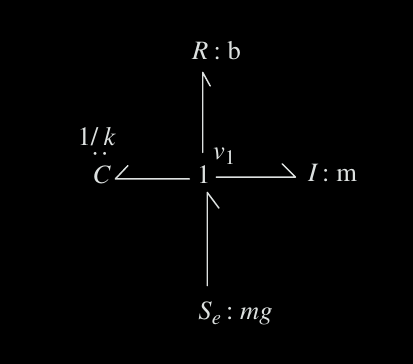

In [3]:
@variables t α
msd = BondGraph(t);

## Create Elements

In [4]:
add_R!(msd, :r1) 
add_C!(msd, :c1)
add_I!(msd, :i1)
F(t, p) = sin(p[1] * t) * p[2]
@register F(t, p)
@parameters α ω ωc
add_Se!(msd, F, [ω, α], :se)

BondGraphs.Element(:Se, ODESystem(Equation[0.0 ~ e(t) - (α*sin(t*ω))], t, Term{Real, Nothing}[e(t), f(t)], Sym{Real, Base.ImmutableDict{DataType, Any}}[ω, α], Equation[], Base.RefValue{Vector{Num}}(Num[]), Base.RefValue{Any}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), :se, ODESystem[], Dict{Any, Any}(), nothing, nothing), Num[])

## Junctions

In [5]:
add_1J!(msd, Dict([
    :r1 => true, 
    :c1 => true, 
    :i1 => true, 
    :se => false]),
    :J1);

## Create Model and Simplify

In [6]:
generate_model!(msd)
simplify_model!(msd)

Any[]

Model ##ODESystem#259 with 2 equations
States (2):
  i1₊p(t)
  c1₊q(t)
Parameters (5):
  i1₊I
  r1₊R
  se₊ω
  se₊α
  c1₊C
Incidence matrix:
 ×  ⋅  ×  ×
 ⋅  ×  ×  ⋅

## Define Initial Conditions

In [7]:
u0 = Dict(
    msd.elements[:i1].sys.p => 0.0,
    msd.elements[:c1].sys.q => 0.0
    )
u0 = ArrayPartition(map(x -> [u0[x]], states(msd.model))...)

([0.0], [0.0])

## Set Problem Parameters with the Frequency have a $\mu$ = 3.0 and $\sigma$ = 1.0 for a Normal Distribution for a MonteCarlo Sampling with 500 Particles

In [8]:
p = Dict(
    msd.elements[:r1].sys.R => 0.1,
    msd.elements[:c1].sys.C => 0.1,
    msd.elements[:i1].sys.I => 1.0,
    msd.elements[:se].sys.α => 1.0,
    msd.elements[:se].sys.ω => 3.0 + 1.0Particles(500),
    )
ps = ArrayPartition(map(x -> [p[x]], parameters(msd.model))...)

([1.0], [0.1], Particles{Float64, 500}[3.0 ± 1.0], [1.0], [0.1])

## Define Timespan

In [15]:
tspan = (0.0, 30.0)

(0.0, 30.0)

## Setup ODE Problem and Solve

In [16]:
func = ODEFunction(msd.model)
prob = ODEProblem(func, u0, tspan, ps)

ODEProblem with uType ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}} and tType Float64. In-place: true
timespan: (0.0, 30.0)
u0: ([0.0], [0.0])

In [17]:
sol = solve(prob, Tsit5());

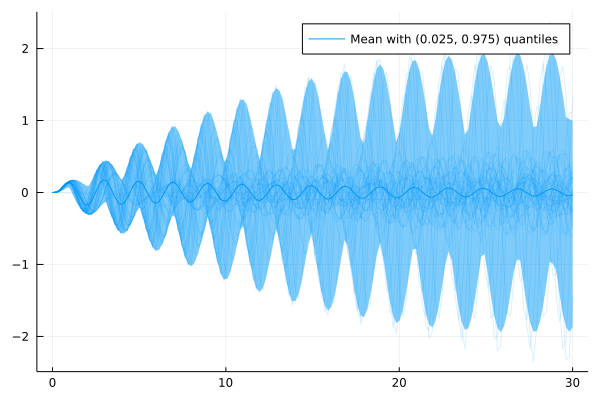

In [18]:
plot(sol.t, sol[msd.elements[:c1].sys.q])

# Nonlinear Elements in the Quarter Car Model
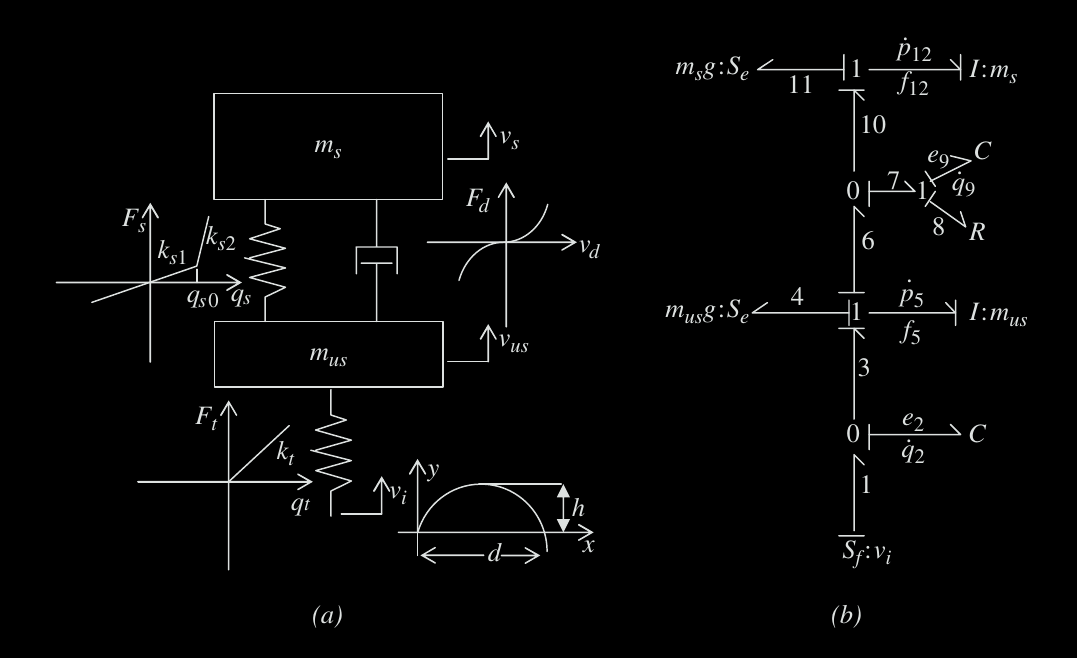

In [19]:
@variables t e(t) f(t) q(t) p(t)
quarterCar = BondGraph(t)

BondGraph(ODESystem(Equation[], t, Any[], Any[], Equation[], Base.RefValue{Vector{Num}}(Num[]), Base.RefValue{Any}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Symbol("##ODESystem#267"), ODESystem[], Dict{Any, Any}(), nothing, nothing), Dict{Symbol, BondGraphs.Element}(), Dict{Symbol, BondGraphs.Junction}(), Dict{Term{Real, Nothing}, Number}(), Sym[])

# Define Problem values

In [20]:
# Bump
U = 0.9
d = 1.0
h = 0.25
# Masses
ms = 320
mus = ms / 6
# Suspension
fs = 1.0
ωs = 2 * π * fs
ks1 = ms * ωs^2
ks2 = 10 * ks1
kt = 10 * ks1
g = 9.81
qs_init = ms * g / ks1
qus_init = (ms + mus) * g / kt
qs0 = 1.3 * qs_init
# Tire
kt = 10 * ks1
# Damper
B = 1500

1500

# Nonlinear Element Equations

In [21]:
# Bump Velocity Input
V(t, p) = (h / d) * π * U * cos(π * U / d * t)

In [21]:
plot(range(0,2.0,length=100), 

In [21]:
# ((U / d) * t <= 1) ?

# : 0.0
@register V(t, p)
# Suspension Spring
ϕks(e, q, t) = (q <= qs0) ? ks1 * q : ks1 * qs0 + ks2 * (q - qs0)
@register ϕks(e, q, t)
# Tire Spring
ϕkus(e, q, t) = (q >= 0.0) ? q * kt : 0.0
@register ϕkus(e, q, t)
# Damper Coefficient
ϕb(e, f, t) = B * f^3
@register ϕb(e, f, t)

# Create Elements

In [22]:
add_Sf!(quarterCar, V, [], :Vin)
add_C!(quarterCar, ϕkus, [], :kt)
add_Bond!(quarterCar, :b3)
add_Se!(quarterCar, mus * g, :Fus)
add_I!(quarterCar, :mus)
add_Bond!(quarterCar, :b6)
add_Bond!(quarterCar, :b7)
add_R!(quarterCar, ϕb, [], :b)
add_C!(quarterCar, ϕks, [], :ks)
add_Bond!(quarterCar, :b10)
add_Se!(quarterCar, ms * g, :Fs)
add_I!(quarterCar, :ms)

BondGraphs.Element(:I, ODESystem(Equation[Differential(t)(p(t)) ~ e(t), f(t) ~ p(t)*(I^-1)], t, Term{Real, Nothing}[e(t), f(t), p(t)], Sym{Real, Base.ImmutableDict{DataType, Any}}[I], Equation[], Base.RefValue{Vector{Num}}(Num[]), Base.RefValue{Any}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), :ms, ODESystem[], Dict{Any, Any}(), nothing, nothing), Num[ms₊p(t)])

In [23]:
# Set Linear parameters
quarterCar.elements[:mus].sys.I = mus
quarterCar.elements[:ms].sys.I = ms
# Add Junctions
add_0J!(quarterCar, Dict([
    :Vin => false, 
    :kt => true, 
    :b3 => true]),
    :J01)
add_1J!(quarterCar, Dict([
    :b3 => false, 
    :mus => true, 
    :Fus => true,
    :b6 => true]), 
    :J11)
add_0J!(quarterCar, Dict([
    :b6 => false, 
    :b7 => true, 
    :b10 => true]), 
    :J02)
add_1J!(quarterCar, Dict([
    :b7 => false, 
    :ks => true,
    :b => true]), 
    :J12)
add_1J!(quarterCar, Dict([
    :b10 => false,
    :Fs => true,
    :ms => true]),
    :J13)

BondGraphs.Junction(:J1, Dict{Symbol, Bool}(:b10 => 0, :Fs => 1, :ms => 1), ODESystem(Equation[0.0 ~ b10₊e(t) - Fs₊e(t) - ms₊e(t), b10₊f(t) ~ Fs₊f(t), Fs₊f(t) ~ ms₊f(t)], t, Term{Real, Nothing}[ms₊e(t), Fs₊e(t), b10₊e(t), b10₊f(t), Fs₊f(t), ms₊f(t)], Any[], Equation[], Base.RefValue{Vector{Num}}(Num[]), Base.RefValue{Any}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Symbol("##ODESystem#270"), ODESystem[], Dict{Any, Any}(), nothing, nothing), Any[])

# Create Model

In [24]:
generate_model!(quarterCar)
simplify_model!(quarterCar)
states(quarterCar.model)

Any[]

7-element Vector{Any}:
 ks₊q(t)
 mus₊p(t)
 kt₊q(t)
 ms₊p(t)
 b₊e(t)
 ks₊e(t)
 kt₊e(t)

# Set initial conditions

In [25]:
u0 = [
    quarterCar.elements[:ks].sys.q  => qs_init,
    quarterCar.elements[:kt].sys.q  => qus_init,
    quarterCar.elements[:mus].sys.p => 0.0,
    quarterCar.elements[:ms].sys.p  => 0.0,
    quarterCar.elements[:b].sys.e   => 0.0,
    quarterCar.elements[:ks].sys.e  => 0.0,
    quarterCar.elements[:kt].sys.e  => 0.0,
    ]|>Dict
u0 = ArrayPartition(map(x -> [u0[x]], states(quarterCar.model))...)

([0.2484902028828334], [0.0], [0.028990523669663894], [0.0], [0.0], [0.0], [0.0])

In [26]:
p = [
    quarterCar.elements[:mus].sys.I => mus,
    quarterCar.elements[:ms].sys.I  => ms,
]|>Dict
ps = ArrayPartition(map(x -> [p[x]], parameters(quarterCar.model))...)

([53.333333333333336], [320.0])

# Set TimeSpan

In [27]:
tspan = (0.0, 2.0)

(0.0, 2.0)

In [28]:
func = ODEFunction(quarterCar.model)
prob = ODEProblem(func, u0, tspan, ps, sparse=true, jac=true)
sol = solve(prob)

retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 604-element Vector{Float64}:
 0.0
 1.0e-6
 1.1e-5
 0.0001071081157030882
 0.0003283436801177855
 0.0006759129408192531
 0.0011596457337484686
 0.0017731766557701817
 0.00252108056224074
 0.00339104076933466
 0.00436647964394957
 0.0054912859882312055
 0.006744463633877446
 ⋮
 1.963292028894573
 1.9667046899446792
 1.9701173509947854
 1.9735300120448915
 1.9769426730949977
 1.980355334145104
 1.98376799519521
 1.9871979662305317
 1.990656277218196
 1.9941514047978768
 1.9976886199474482
 2.0
u: 604-element Vector{ArrayPartition{Float64, NTuple{7, Vector{Float64}}}}:
 ([0.2484902028828334], [0.0], [0.028990523669663894], [0.0], [0.0], [3139.2000000000003], [3662.4])
 ([0.2484902028828337], [4.464903843326778e-8], [0.02899123052801067], [9.580374307071888e-19], [8.800987712865336e-25], [3139.200000000004], [3662.4892980768036])
 ([0.24849020288320486], [5.402533504138872e-6], [0.02899829911110889

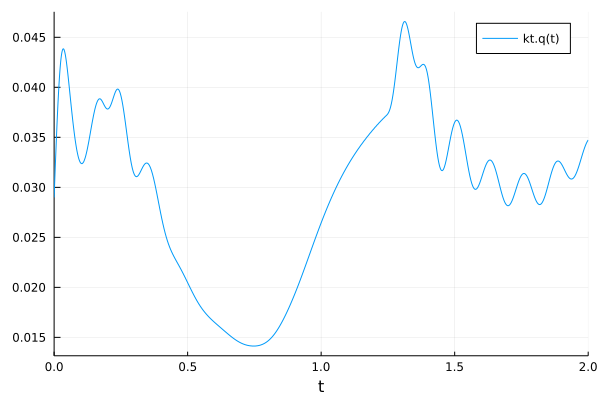

In [33]:
plot(sol, vars=[quarterCar.elements[:kt].sys.q]) 

# Implementation of an Algebraic Loop Equation 
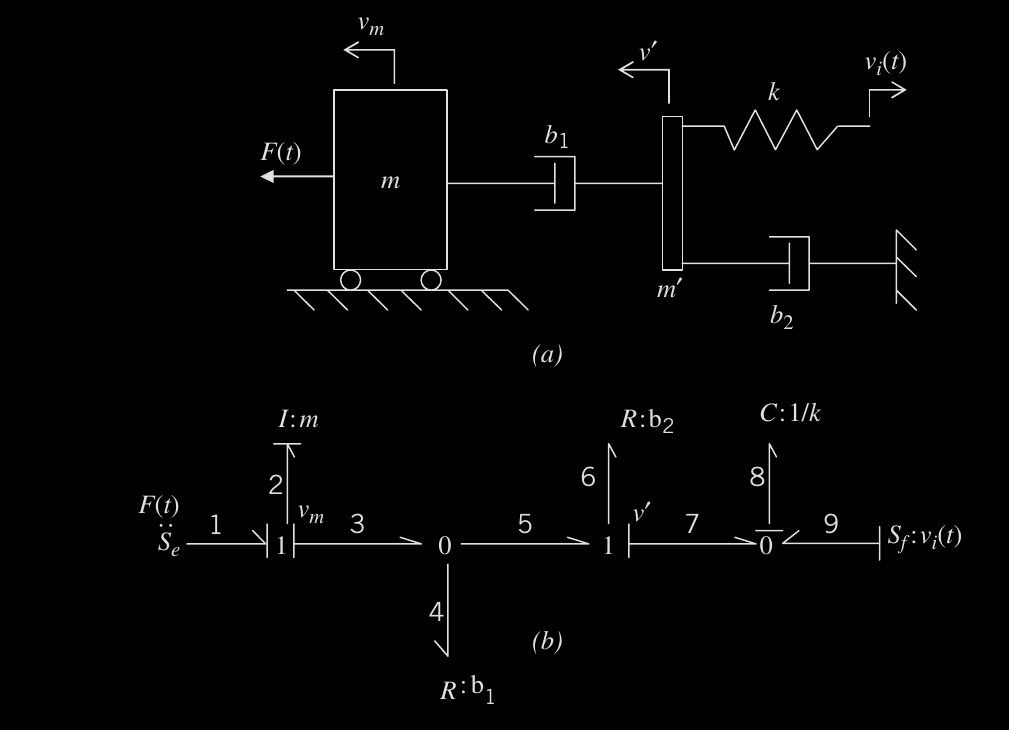

In [25]:
@variables t
@parameters α β γ δ
fig5_10 = BondGraph(t)

BondGraph(ODESystem(Equation[], t, Any[], Any[], Equation[], Base.RefValue{Vector{Num}}(Num[]), Base.RefValue{Any}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Symbol("##ODESystem#445"), ODESystem[], Dict{Any, Any}(), nothing, nothing), Dict{Symbol, BondGraphs.Element}(), Dict{Symbol, BondGraphs.Junction}(), Dict{Term{Real, Nothing}, Number}(), Sym[])

# Add Elements

In [26]:
F(t, p) = p[1] * sin(p[2]*t)
@register F(t, p)
add_Se!(fig5_10, F, [α, β], :S_e)
add_I!(fig5_10, :I_2)
add_R!(fig5_10, :R_4)
add_R!(fig5_10, :R_6)
add_C!(fig5_10, :C_8)
add_Sf!(fig5_10, F, [γ, δ], :S_f)
add_Bond!(fig5_10, :b_3)
add_Bond!(fig5_10, :b_5)
add_Bond!(fig5_10, :b_7)

BondGraphs.Element(:B, ODESystem(Equation[], t, Term{Real, Nothing}[e(t), f(t)], Any[], Equation[], Base.RefValue{Vector{Num}}(Num[]), Base.RefValue{Any}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), :b_7, ODESystem[], Dict{Any, Any}(), nothing, nothing), Num[])

# Add Junctions

In [27]:
add_1J!(fig5_10, Dict([
    :S_e => false,
    :I_2 => true,
    :b_3 => true
    ]),
    :J10)
add_0J!(fig5_10, Dict([
    :b_3 => false,
    :R_4 => true,
    :b_5 => true
    ]),
    :J01)
add_1J!(fig5_10, Dict([
    :b_5 => false,
    :R_6 => true,
    :b_7 => true   
    ]),
    :J12)
add_0J!(fig5_10, Dict([
    :b_7 => false,
    :C_8 => true,
    :S_f => false
    ]),
    :J02)

BondGraphs.Junction(:J0, Dict{Symbol, Bool}(:C_8 => 1, :S_f => 0, :b_7 => 0), ODESystem(Equation[0.0 ~ S_f₊f(t) + b_7₊f(t) - C_8₊f(t), C_8₊e(t) ~ S_f₊e(t), S_f₊e(t) ~ b_7₊e(t)], t, Any[], Any[], Equation[], Base.RefValue{Vector{Num}}(Num[]), Base.RefValue{Any}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), :J02, ODESystem[], Dict{Any, Any}(), nothing, nothing))

# Create system

In [28]:
generate_model!(fig5_10)

Model ##ODESystem#448 with 20 equations
States (20):
  b_5₊e(t)
  b_7₊e(t)
  R_6₊e(t)
  R_6₊f(t)
  b_5₊f(t)
  b_7₊f(t)
⋮
Parameters (8):
  C_8₊C
  I_2₊I
  R_6₊R
  R_4₊R
  S_f₊γ
  S_f₊δ
⋮

In [29]:
fig5_10.model = initialize_system_structure(fig5_10.model)
fig5_10.model = alias_elimination(fig5_10.model)
fig5_10.model = tearing(fig5_10.model)
fig5_10.model = initialize_system_structure(fig5_10.model)

Model ##ODESystem#448 with 3 equations
States (3):
  C_8₊q(t)
  I_2₊p(t)
  R_4₊f(t)
Parameters (8):
  C_8₊C
  I_2₊I
  R_6₊R
  R_4₊R
  S_f₊γ
  S_f₊δ
⋮
Incidence matrix:
 ×  ⋅  ⋅  ×  ×
 ⋅  ×  ×  ×  ×
 ⋅  ⋅  ×  ×  ×

# Set Parameters

In [30]:
p = [
    fig5_10.elements[:S_e].sys.α => 1.0,
    fig5_10.elements[:S_e].sys.β => 2.0,
    fig5_10.elements[:S_f].sys.γ => 3.0,
    fig5_10.elements[:S_f].sys.δ => 4.0,
    fig5_10.elements[:I_2].sys.I => 5.0,
    fig5_10.elements[:R_4].sys.R => 6.0,
    fig5_10.elements[:R_6].sys.R => 7.0,
    fig5_10.elements[:C_8].sys.C => 8.0
]|>Dict
ps = ArrayPartition(map(x -> [p[x]], parameters(fig5_10.model))...)

([8.0], [5.0], [7.0], [6.0], [3.0], [4.0], [1.0], [2.0])

# Set Initial Conditions

In [31]:
u0 = [
    fig5_10.elements[:I_2].sys.p => 0.0,
    fig5_10.elements[:C_8].sys.q => 0.0,
    fig5_10.elements[:R_4].sys.f => 0.0,
]|>Dict
u0 = ArrayPartition(map(x -> [u0[x]], states(fig5_10.model))...)

([0.0], [0.0], [0.0])

# Set TimeSpan

In [32]:
tspan = (0.0, 2.0)

(0.0, 2.0)

In [33]:
func = ODEFunction(fig5_10.model)
prob = ODEProblem(func, u0, tspan, ps)

ODEProblem with uType ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}} and tType Float64. In-place: true
timespan: (0.0, 2.0)
u0: ([0.0], [0.0], [0.0])

In [34]:
sol = solve(prob)

retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 485-element Vector{Float64}:
 0.0
 1.0e-6
 4.204472319806859e-6
 1.1035749428002335e-5
 2.2209166558766898e-5
 3.8436797389634156e-5
 6.125794519428997e-5
 9.194861878028667e-5
 0.0001317833100214416
 0.00018185650272325684
 0.00024306971039207107
 0.00031608667137781606
 0.0004013301029355893
 ⋮
 1.8979960278887105
 1.906435823785071
 1.9151766291766816
 1.9242209421662295
 1.933564457146795
 1.9431944868388025
 1.9530892014068282
 1.963218163375422
 1.9735442071555285
 1.9840262275104716
 1.9946226611801732
 2.0
u: 485-element Vector{ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}}}:
 ([0.0], [0.0], [0.0])
 ([4.954667190225441e-12], [8.25777747063979e-13], [1.3657094189751928e-13])
 ([9.428604337440818e-11], [1.5714323672726874e-11], [2.598908351047589e-12])
 ([6.701652590272314e-10], [1.1169385238063215e-10], [1.847246543932992e-11])
 ([2.768416399834683e-9]

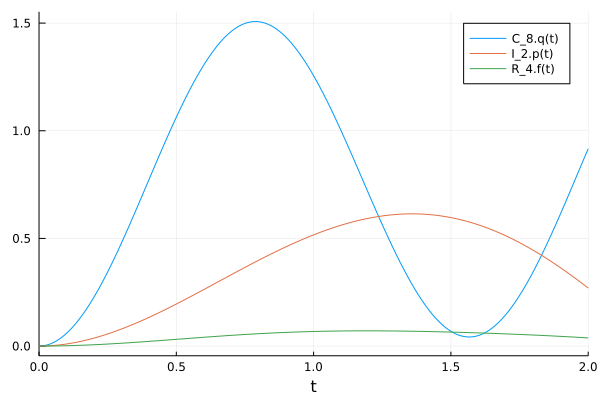

In [35]:
plot(sol)

# Transverse Half Car Model with Units!
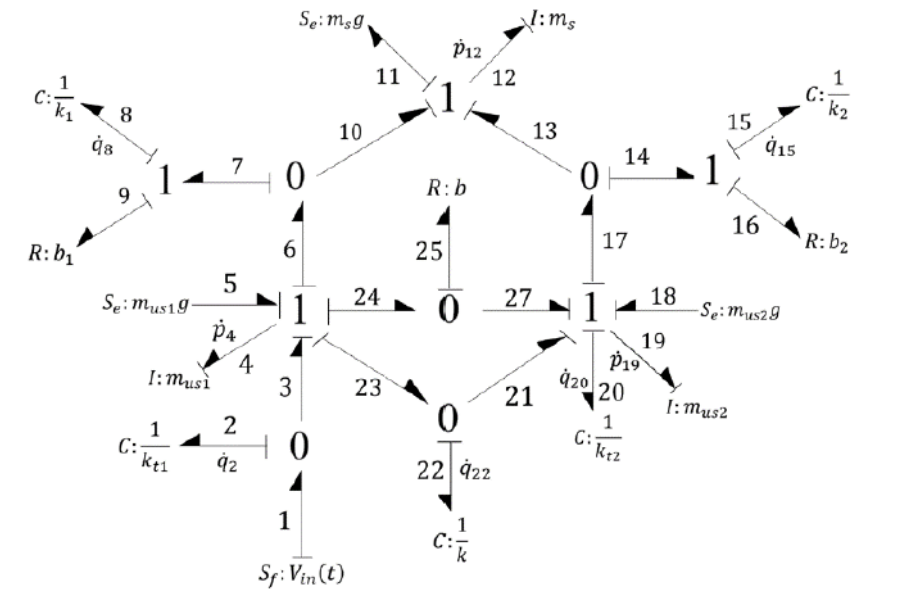

## Problem Independent Variable and Power Variables

In [18]:
@variables t e(t) f(t) 
@parameters ω α

2-element Vector{Num}:
 ω
 α

In [19]:
halfcar = BondGraph(t)

BondGraph(ODESystem(Equation[], t, Any[], Any[], Equation[], Base.RefValue{Vector{Num}}(Num[]), Base.RefValue{Any}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Symbol("##ODESystem#290"), ODESystem[], Dict{Any, Any}(), nothing, nothing), Dict{Symbol, BondGraphs.Element}(), Sym[], Dict{Symbol, BondGraphs.Junction}(), Dict{Term{Real, Nothing}, Number}(), Sym[])

In [36]:
v_in(t, p) = p[1] * sin(p[2] * t)
@register v_in(t, p)

# Setup the Bonds

In [37]:
add_Sf!(halfcar, v_in, [α, ω], :sf1)
add_C!(halfcar, :c2)
add_Bond!(halfcar, :b3)
add_0J!(halfcar, Dict([
    :sf1 => false,
    :c2 => true,
    :b3 => true
    ]),
    :J1)
add_I!(halfcar, :i4)
add_Se!(halfcar, :se5)
add_Bond!(halfcar, :b6)
add_Bond!(halfcar, :b24)
add_Bond!(halfcar, :b23)
add_1J!(halfcar, Dict([
    :b3 => false,
    :i4 => true,
    :se5 => false,
    :b6 => true,
    :b23 => true,
    :b24 => true
    ]), 
    :J2)
add_Bond!(halfcar, :b7)
add_Bond!(halfcar, :b10)
add_0J!(halfcar, Dict([
    :b6 => false,
    :b7 => true,
    :b10 => true
    ]),
    :J3)
add_C!(halfcar, :c8)
add_R!(halfcar, :r9)
add_1J!(halfcar, Dict([
    :b7 => false,
    :c8 => true,
    :r9 => true
    ]),
    :J4)
add_Se!(halfcar, :se11)
add_I!(halfcar, :i12)
add_Bond!(halfcar, :b13)
add_1J!(halfcar, Dict([
    :b10 => false,
    :se11 => true,
    :i12 => true,
    :b13 => false
    ]),
    :J5)
add_Bond!(halfcar, :b14)
add_Bond!(halfcar, :b17)
add_0J!(halfcar, Dict([
    :b13 => true,
    :b14 => true,
    :b17 => false
    ]),
    :J6)
add_C!(halfcar, :c15)
add_R!(halfcar, :r16)
add_1J!(halfcar, Dict([
    :b14 => false,
:c15 => true,
    :r16 => true
    ]),
    :J7)
add_Se!(halfcar, :se18)
add_I!(halfcar, :i19)
add_C!(halfcar, :c20)
add_Bond!(halfcar, :b21)
add_Bond!(halfcar, :b27)
add_1J!(halfcar, Dict([
    :b17 => true,
    :se18 => false,
    :i19 => true,
    :c20 => true,
    :b21 => false,
    :b27 => false
    ]),
    :J8)
add_C!(halfcar, :c22)
add_0J!(halfcar, Dict([
    :b21 => true,
    :c22 => true,
    :b23 => false
    ]),
    :J9)
add_R!(halfcar, :r25)
add_0J!(halfcar, Dict([
    :b24 => false,
    :r25 => true,
    :b27 => true
    ]),
    :J10)

BondGraphs.Junction(:J0, Dict{Symbol, Bool}(:b24 => 0, :b27 => 1, :r25 => 1), ODESystem(Equation[0.0 ~ b24₊f(t) - b27₊f(t) - r25₊f(t), b24₊e(t) ~ b27₊e(t), b27₊e(t) ~ r25₊e(t)], t, Any[], Any[], Equation[], Base.RefValue{Vector{Num}}(Num[]), Base.RefValue{Any}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), Base.RefValue{Matrix{Num}}(Matrix{Num}(undef, 0, 0)), :J10, ODESystem[], Dict{Any, Any}(), nothing, nothing), Any[])

# Generate Model

In [38]:
generate_model!(halfcar)
simplify_model!(halfcar)

Any[]

Model ##ODESystem#457 with 8 equations
States (8):
  i19₊p(t)
  c8₊q(t)
  c2₊q(t)
  i12₊p(t)
  i4₊p(t)
  c15₊q(t)
⋮
Parameters (16):
  i19₊I
  se18₊Se(t)
  c8₊C
  r25₊R
  c2₊C
  se11₊Se(t)
⋮
Incidence matrix:
⠑⢄⠀⠀⣁⢘⣏⠉
⠀⠀⠑⢄⡏⠙⡁⠈

# Define Initial Conditions

In [39]:
u0 = [
halfcar.elements[:c2].sys.q  => 0.0u"m",
halfcar.elements[:c8].sys.q  => 0.0u"m",
halfcar.elements[:c15].sys.q => 0.0u"m",
halfcar.elements[:c22].sys.q => 0.0u"m",
halfcar.elements[:i4].sys.p  => 0.0u"kg*m/s",
halfcar.elements[:i12].sys.p => 0.0u"kg*m/s",
halfcar.elements[:i19].sys.p => 0.0u"kg*m/s",
halfcar.elements[:c20].sys.q => 0.0u"m",
] |> Dict
u0 = ArrayPartition(map(x -> [u0[x]], states(halfcar.model))...)

(Quantity{Float64, 𝐋 𝐌 𝐓^-1, Unitful.FreeUnits{(kg, m, s^-1), 𝐋 𝐌 𝐓^-1, nothing}}[0.0 kg m s^-1], Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}[0.0 m], Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}[0.0 m], Quantity{Float64, 𝐋 𝐌 𝐓^-1, Unitful.FreeUnits{(kg, m, s^-1), 𝐋 𝐌 𝐓^-1, nothing}}[0.0 kg m s^-1], Quantity{Float64, 𝐋 𝐌 𝐓^-1, Unitful.FreeUnits{(kg, m, s^-1), 𝐋 𝐌 𝐓^-1, nothing}}[0.0 kg m s^-1], Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}[0.0 m], Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}[0.0 m], Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}[0.0 m])

# Set Parameters

In [49]:
p = [
halfcar.elements[:sf1].sys.α  => 1.0u"m/s",
halfcar.elements[:sf1].sys.ω  => 20.0u"rad/s",
halfcar.elements[:c2].sys.C   => 1.0u"m/N",
halfcar.elements[:i4].sys.I   => 1.0u"kg",
halfcar.elements[:se5].sys.Se => 9.81u"N",
halfcar.elements[:c8].sys.C   => 1.0u"m/N",
halfcar.elements[:r9].sys.R   => 0.2u"N*s/m",
halfcar.elements[:i12].sys.I  => 1.0u"kg",
halfcar.elements[:se11].sys.Se => 9.82u"N",
halfcar.elements[:c15].sys.C  => 1.0u"m/N",
halfcar.elements[:r16].sys.R  => 0.2u"N*s/m",
halfcar.elements[:i19].sys.I  => 2.0u"kg",
halfcar.elements[:se18].sys.Se => 9.83u"N",
halfcar.elements[:c20].sys.C  => 1.0u"m/N",
halfcar.elements[:c22].sys.C  => 1.0u"m/N",
halfcar.elements[:r25].sys.R  => 0.2u"N*s/m",
] |> Dict
ps = ArrayPartition(map(x -> [p[x]], parameters(halfcar.model))...)
map(x-> prob.p[x] = ps[x], eachindex(prob.p))

16-element Vector{Quantity{Float64, D, U} where {D, U}}:
        2.0 kg
        9.83 N
    1.0 m N^-1
  0.2 N s m^-1
    1.0 m N^-1
        9.82 N
        9.81 N
  0.2 N s m^-1
    1.0 m s^-1
 20.0 rad s^-1
        1.0 kg
        1.0 kg
    1.0 m N^-1
    1.0 m N^-1
    1.0 m N^-1
  0.2 N s m^-1

# Set Timespan

In [41]:
tspan = (0.0u"s", 10.0u"s")

(0.0 s, 10.0 s)

In [42]:
func = ODEFunction(halfcar.model)

In [42]:
prob = ODEProblem(func, u0, tspan, ps)

ODEProblem with uType ArrayPartition{Quantity{Float64, D, U} where {D, U}, Tuple{Vector{Quantity{Float64, 𝐋 𝐌 𝐓^-1, Unitful.FreeUnits{(kg, m, s^-1), 𝐋 𝐌 𝐓^-1, nothing}}}, Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}, Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}, Vector{Quantity{Float64, 𝐋 𝐌 𝐓^-1, Unitful.FreeUnits{(kg, m, s^-1), 𝐋 𝐌 𝐓^-1, nothing}}}, Vector{Quantity{Float64, 𝐋 𝐌 𝐓^-1, Unitful.FreeUnits{(kg, m, s^-1), 𝐋 𝐌 𝐓^-1, nothing}}}, Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}, Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}, Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}}}} and tType Quantity{Float64, 𝐓, Unitful.FreeUnits{(s,), 𝐓, nothing}}. In-place: true
timespan: (0.0 s, 10.0 s)
u0: (Quantity{Float64, 𝐋 𝐌 𝐓^-1, Unitful.FreeUnits{(kg, m, s^-1), 𝐋 𝐌 𝐓^-1, nothing}}[0.0 kg m s^-1], Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}[0.0 m], Quantity{Float64, 𝐋, Unitful.FreeUn

In [52]:
sol = solve(prob, Tsit5());

In [50]:
p[]

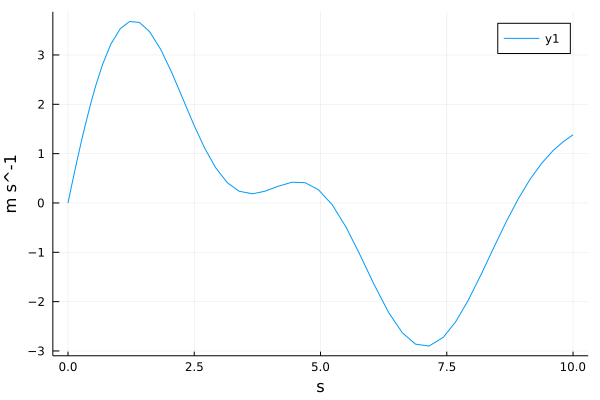

In [51]:
plot(sol.t, sol[halfcar.elements[:c20].sys.f])

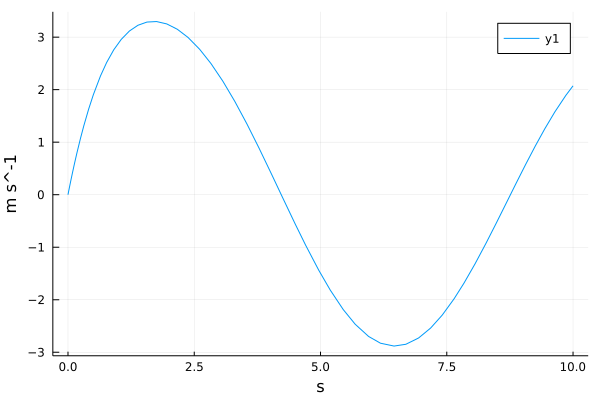

In [45]:
plot(sol.t, sol[halfcar.elements[:c20].sys.f])

# Transfer Functions: Amplitude Ratios and Phase Angles

In [ ]:
@variables t α
msd = BondGraph(t) 
# Elements
add_R!(msd, :r1) 
add_C!(msd, :c1)
add_I!(msd, :i1)
@variables Se
add_Se!(msd, Se, :se)
# Junctions
add_1J!(msd, Dict([
    :r1 => true, 
    :c1 => true, 
    :i1 => true, 
    :se => false]),
    :J1)
generate_model!(msd)
simplify_model!(msd)

In [3]:
ps = Dict(
    msd.elements[:r1].sys.R => 1.0,
    msd.elements[:c1].sys.C => 0.1,
    msd.elements[:i1].sys.I => 1.0..0.2,
    msd.elements[:se].sys.Se => Se
    )
# ps = ArrayPartition(map(x -> [p[x]], parameters(msd.model))...)
C = [1 1; 1 1]
D = [0; 0]
tf = transfer_function(msd, ps, C, D);
@variables ω
G = eval(tf[1])
abs.(G(im))
ω = 10.0.^range(-4, 6.0, length=10000)
plot(ω, transpose(abs.(reduce(hcat, (G.(ω * im))))), xscale=:log10, yscale=:log10)

LoadError: MethodError: [0mCannot `convert` an object of type 
[0m  [92mVector{Sym{Real, Base.ImmutableDict{DataType, Any}}}[39m[0m to an object of type 
[0m  [91mSym[39m
[0mClosest candidates are:
[0m  convert(::Type{Sym}, [91m::Num[39m) at /home/carson/.julia/packages/Symbolics/sITWZ/src/num.jl:188
[0m  convert(::Type{T}, [91m::T[39m) where T at essentials.jl:205

In [21]:
@variables t e(t) f(t) 
halfcar = BondGraph(t)
@variables Sf1
add_Sf!(halfcar, Sf1, :sf1)
add_C!(halfcar, :c2)
add_Bond!(halfcar, :b3)
add_0J!(halfcar, Dict([
    :sf1 => false,
    :c2 => true,
    :b3 => true
    ]),
    :J1)
add_I!(halfcar, :i4)
add_Se!(halfcar, :se5)
add_Bond!(halfcar, :b6)
add_Bond!(halfcar, :b24)
add_Bond!(halfcar, :b23)
add_1J!(halfcar, Dict([
    :b3 => false,
    :i4 => true,
    :se5 => false,
    :b6 => true,
    :b23 => true,
    :b24 => true
    ]), 
    :J2)
add_Bond!(halfcar, :b7)
add_Bond!(halfcar, :b10)
add_0J!(halfcar, Dict([
    :b6 => false,
    :b7 => true,
    :b10 => true
    ]),
    :J3)
add_C!(halfcar, :c8)
add_R!(halfcar, :r9)
add_1J!(halfcar, Dict([
    :b7 => false,
    :c8 => true,
    :r9 => true
    ]),
    :J4)
add_Se!(halfcar, :se11)
add_I!(halfcar, :i12)
add_Bond!(halfcar, :b13)
add_1J!(halfcar, Dict([
    :b10 => false,
    :se11 => true,
    :i12 => true,
    :b13 => false
    ]),
    :J5)
add_Bond!(halfcar, :b14)
add_Bond!(halfcar, :b17)
add_0J!(halfcar, Dict([
    :b13 => true,
    :b14 => true,
    :b17 => false
    ]),
    :J6)
add_C!(halfcar, :c15)
add_R!(halfcar, :r16)
add_1J!(halfcar, Dict([
    :b14 => false,
:c15 => true,
    :r16 => true
    ]),
    :J7)
add_Se!(halfcar, :se18)
add_I!(halfcar, :i19)
add_C!(halfcar, :c20)
add_Bond!(halfcar, :b21)
add_Bond!(halfcar, :b27)
add_1J!(halfcar, Dict([
    :b17 => true,
    :se18 => false,
    :i19 => true,
    :c20 => true,
    :b21 => false,
    :b27 => false
    ]),
    :J8)
add_C!(halfcar, :c22)
add_0J!(halfcar, Dict([
    :b21 => true,
    :c22 => true,
    :b23 => false
    ]),
    :J9)
add_R!(halfcar, :r25)
add_0J!(halfcar, Dict([
    :b24 => false,
    :r25 => true,
    :b27 => true
    ]),
    :J10)

LoadError: ArgumentError: Variable Sf does not exist